In [193]:
import conf

env = 'colab' if 'google.colab' in str(get_ipython()) else 'local'
if env == 'colab':
  print('Running on CoLab')
  !pip install dypac
  import sys
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  BASE_DIR = 'ValuePercept'
  sys.path.append('/content/drive/My Drive/{}'.format(BASE_DIR))
else:
  print('Running locally')
  BASE_DIR = conf.BASE_DIR

Running locally


In [256]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import csv

import hcp_utils as hcp
import feature_selec_functions
import conf

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import plot_con_helper
import feature_selec_functions
import importlib

# Load connectome data

In [257]:
#path to matrices
file_name = BASE_DIR + conf.X_FEATURES_DIR + conf.X_FEATURES_FILENAME

#path to subject IDs 
path_sub = BASE_DIR + conf.X_FEATURES_DIR + conf.SUB_ID_FILENAME

#path to behavioral data (analyzed in the analyze_behavior notebook)
path_behavior = BASE_DIR + 'Behavior/HCP_behavior_includeZscores_V3.csv'

X_features = np.load(file_name)['a']
subject_IDs = np.loadtxt(path_sub)
subject_IDs = subject_IDs.astype(int) #turn the subject IDS into integers
df = pd.read_csv(path_behavior)

In [258]:
X_features.shape

(992, 100, 100)

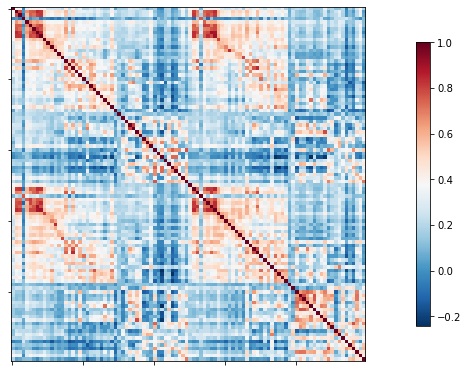

In [259]:
#Example how it looks for one subject
correlation_matrix = X_features[90]
# Mask the main diagonal for visualization:
# np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix)

# Equalize number of subjects in x_features and behavior

In [260]:
import model_preparation_functions
import importlib

importlib.reload(model_preparation_functions)

X_features, df, subject_IDs = model_preparation_functions.equalize(X_features, df, subject_IDs)

#Set subject ID as index
df = df.set_index('Subject')

Before equalization:
Number of subjects in x_features is 992
And, the number of subjects in the behavior data is 979
So, the difference between the two data sets is 13
After equalization:
Number of subjects in x_features is 979
And, the number of subjects in the behavior data is 979
So, the difference between the two data sets is 0


# Prepare x_features to the model

In [261]:
importlib.reload(model_preparation_functions)

vectorized_edges = model_preparation_functions.vectorize_mat(X_features, subject_IDs)

nodes_map = vectorized_edges.columns

The number of vectorized edges is 4950
Make sure it equals num_nodes*(num_nodes-1)/2


In [262]:
#sort all_fc_data according to index (same as behavior data)
all_fc_data = vectorized_edges.sort_index()
all_fc_data.head(5)

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(0, 10)",...,"(95, 96)","(95, 97)","(95, 98)","(95, 99)","(96, 97)","(96, 98)","(96, 99)","(97, 98)","(97, 99)","(98, 99)"
100206,0.249926,0.290333,-0.035176,0.124437,0.196000,0.182704,0.143909,0.135128,0.236151,0.165689,...,0.548640,0.437592,0.371191,0.606679,0.395285,0.193468,0.434434,0.476877,0.519436,0.486034
100307,0.200340,0.227143,-0.044502,0.147324,0.202223,0.138166,0.173984,0.156175,0.151013,0.100776,...,0.467784,0.531214,0.498063,0.636941,0.563660,0.334243,0.558858,0.530248,0.576540,0.576324
100408,0.482891,0.485075,0.398771,0.455051,0.502008,0.438331,0.419254,0.427509,0.479415,0.476058,...,0.530054,0.382487,0.583871,0.635355,0.309884,0.350733,0.484284,0.355986,0.446437,0.667915
100610,0.379997,0.393513,-0.020961,0.320748,0.403028,0.390072,0.394438,0.371797,0.387755,0.284788,...,0.574221,0.380659,0.288863,0.552819,0.445938,0.173063,0.585484,0.484497,0.467707,0.438245
101006,0.189229,0.184994,0.102680,0.252590,0.170402,0.120129,0.113304,0.084868,0.042109,0.016010,...,0.392105,0.341949,0.355639,0.496079,0.422337,0.207884,0.486177,0.509836,0.532823,0.541860


In [263]:
#scaling of x_features
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std
    
# call the z_score function
all_fc_data_standardized = z_score(all_fc_data)

all_fc_data_standardized.head(5)

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(0, 10)",...,"(95, 96)","(95, 97)","(95, 98)","(95, 99)","(96, 97)","(96, 98)","(96, 99)","(97, 98)","(97, 99)","(98, 99)"
100206,-0.171753,-0.115187,-1.460994,-1.094465,-0.772648,-0.606199,-0.772276,-0.749595,-0.113972,-0.425408,...,0.369507,-0.038327,-0.364850,0.239788,-0.432794,-0.267975,-0.804360,0.116783,0.002374,-0.129298
100307,-0.507616,-0.565021,-1.539517,-0.899563,-0.723186,-0.939933,-0.567457,-0.603244,-0.774480,-0.921414,...,-0.467831,0.828676,0.976837,0.601651,1.068377,1.032697,0.618838,0.732225,0.594236,0.951360
100408,1.406218,1.271115,2.193028,1.721019,1.659381,1.309305,1.102877,1.283557,1.773289,1.946138,...,0.177034,-0.548632,1.884264,0.582683,-1.194199,1.185047,-0.234154,-1.277256,-0.754237,2.047590
100610,0.709271,0.619311,-1.341292,0.577301,0.872728,0.947686,0.933878,0.896147,1.062183,0.484633,...,0.634426,-0.565554,-1.235469,-0.404258,0.018811,-0.456505,0.923399,0.204647,-0.533775,-0.701276
101006,-0.582875,-0.865063,-0.300182,-0.003123,-0.976090,-1.075094,-0.980705,-1.099095,-1.619361,-1.569115,...,-1.251554,-0.924040,-0.529313,-1.082737,-0.191609,-0.134774,-0.212511,0.496843,0.141128,0.538862


# Display the Y variable (Behavior)

<AxesSubplot:xlabel='z_score_noise'>

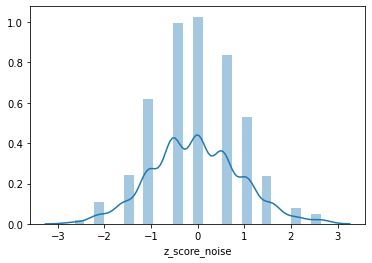

In [264]:
#Behavior
behav_list = ["Mars_Final", "z_score_mars", "DDisc_AUC_40K", "z_score_DDisc_AUC", 'Flanker_AgeAdj', 'z_score_Flanker', 'z_score_compare_f', 'z_score_compare', 'CardSort_AgeAdj', 'z_score_CardSort', 'z_score_PicSeq', 'z_score_LisSort', 'z_score_noise']

behav = df[behav_list[12]]

sns.distplot(behav)


<AxesSubplot:xlabel='Noise_Comp'>

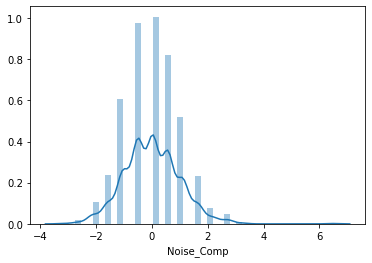

In [204]:
#Scaling of the z_compare_F
behav_scaled = (behav - np.mean(behav,axis=0))/np.std(behav,axis=0)
sns.distplot(behav_scaled)

In [265]:
#Make sure the subject lists in the fMRI data and behavior data are equal
assert all_fc_data_standardized.index.equals(df.index), "Row (subject) indices of FC vcts and behavior don't match!"

## Correlation between features and the Y variable

In [266]:
score_y = behav
X_features = all_fc_data_standardized

In [267]:
import feature_selec_functions
import importlib

importlib.reload(feature_selec_functions)

mask_dict, corr = feature_selec_functions.select_features(X_features, score_y, percent = 0.05, corr_type='pearson', verbose=False)
print(len(mask_dict[mask_dict == True]))
print(mask_dict)

#Make sure there are also negetaive edges

0.05696967285047718
(0, 98)    -0.059007
(1, 38)    -0.058179
(3, 30)    -0.060086
(3, 36)    -0.063421
(3, 78)    -0.066363
              ...   
(90, 98)   -0.085378
(93, 98)   -0.086137
(95, 98)   -0.099920
(95, 99)   -0.087697
(98, 99)   -0.093990
Length: 247, dtype: float64
4950
247
(0, 1)      False
(0, 2)      False
(0, 3)      False
(0, 4)      False
(0, 5)      False
            ...  
(96, 98)    False
(96, 99)    False
(97, 98)    False
(97, 99)    False
(98, 99)     True
Length: 4950, dtype: bool


### Parc identities as network names

In [268]:
#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()
    
#lines

In [269]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
#list_parcel

In [270]:
#create a list of dictionaries which identifies each relevant pair of nodes and attach its beta
res = []
list_edges = all_fc_data.columns
con = corr

for i in range(len(list_edges)):
    dict_res = {}
    tup = list_edges[i] #tupple(pair of nodes)
    parcel_index = tup[0] #tupples and list_parcels are listed from zero
    dict_res["node1"] = list_parcel[parcel_index]
    parcel_index = tup[1]
    dict_res["node2"] = list_parcel[parcel_index]
    dict_res["R"] = corr[i]
    dict_res["R_abs"] = abs(corr[i])
    res.append(dict_res)
res

[{'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_2',
  'R': -0.005942729689033547,
  'R_abs': 0.005942729689033547},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_3',
  'R': -0.010571770562821606,
  'R_abs': 0.010571770562821606},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_4',
  'R': 0.010230648632126015,
  'R_abs': 0.010230648632126015},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_5',
  'R': -0.010215946347512052,
  'R_abs': 0.010215946347512052},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_6',
  'R': -0.009614148303355361,
  'R_abs': 0.009614148303355361},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_7',
  'R': -0.021954359797144416,
  'R_abs': 0.021954359797144416},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_8',
  'R': -0.012214358777221209,
  'R_abs': 0.012214358777221209},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_Vis_9',
  'R': -0.00445253232994351,
  'R_abs': 0.00445253232994351},
 {'node1': 'LH_Vis_1',
  'node2': 'LH_SomMot_1',
  'R': -0.021662725574474396,
  'R_abs': 0.021662725574474396},
 {'node1':

In [271]:
df_res = pd.DataFrame(res)
df_res

,node1,node2,R,R_abs
0,LH_Vis_1,LH_Vis_2,-0.005943,0.005943
1,LH_Vis_1,LH_Vis_3,-0.010572,0.010572
2,LH_Vis_1,LH_Vis_4,0.010231,0.010231
3,LH_Vis_1,LH_Vis_5,-0.010216,0.010216
4,LH_Vis_1,LH_Vis_6,-0.009614,0.009614
...,...,...,...,...
4945,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_1,-0.036487,0.036487
4946,RH_Default_PFCdPFCm_2,RH_Default_pCunPCC_2,-0.015665,0.015665
4947,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_1,-0.025306,0.025306
4948,RH_Default_PFCdPFCm_3,RH_Default_pCunPCC_2,0.009685,0.009685


In [272]:
df_res = df_res.sort_values(by=['R_abs'], ascending=False,  ignore_index=True)
df_res.head(50)

,node1,node2,R,R_abs
0,LH_Limbic_TempPole_2,LH_Default_PFC_2,-0.104966,0.104966
1,RH_Default_PFCdPFCm_1,RH_Default_pCunPCC_1,-0.099920,0.099920
2,LH_Default_Temp_2,LH_Default_PFC_4,-0.099693,0.099693
3,RH_Cont_Par_1,RH_Cont_PFCl_3,-0.099665,0.099665
4,LH_Default_pCunPCC_1,RH_Default_pCunPCC_1,-0.098399,0.098399
5,LH_Default_PFC_2,RH_SomMot_6,-0.097034,0.097034
6,LH_Default_PFC_2,LH_Default_PFC_6,-0.096766,0.096766
7,LH_Limbic_TempPole_2,RH_SomMot_6,-0.095192,0.095192
8,LH_Limbic_TempPole_2,LH_Default_PFC_7,-0.095101,0.095101
9,LH_Default_PFC_2,RH_SomMot_8,-0.094934,0.094934


In [273]:
df_res.to_csv(conf.RESULTS_DIR + 'reg_noise.csv') #Change name of file according to the task

## Plot results

In [274]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

#Paths to results 
PATH = conf.RESULTS_DIR

#Plot results of all 3 tasks
dfs = ['reg_noise', 'reg_MC']

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'R', 'R_abs']]
    df_arranged[dfs[i]] = df
    
## The dfs has the same edges and are already sorted according to R_abs.

In [275]:
df_arranged['reg_noise']

,node1,node2,R,R_abs
0,LH_Limbic_TempPole_2,LH_Default_PFC_2,-0.104966,0.104966
1,RH_Default_PFCdPFCm_1,RH_Default_pCunPCC_1,-0.099920,0.099920
2,LH_Default_Temp_2,LH_Default_PFC_4,-0.099693,0.099693
3,RH_Cont_Par_1,RH_Cont_PFCl_3,-0.099665,0.099665
4,LH_Default_pCunPCC_1,RH_Default_pCunPCC_1,-0.098399,0.098399
...,...,...,...,...
4945,LH_SomMot_1,RH_SomMot_6,-0.000051,0.000051
4946,LH_SomMot_3,RH_Limbic_TempPole_1,-0.000033,0.000033
4947,LH_SomMot_2,RH_SalVentAttn_Med_1,-0.000022,0.000022
4948,LH_Vis_4,RH_SomMot_4,0.000007,0.000007


In [276]:
importlib.reload(plot_con_helper)

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for key in df_arranged.keys():
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df_arranged[key])
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)

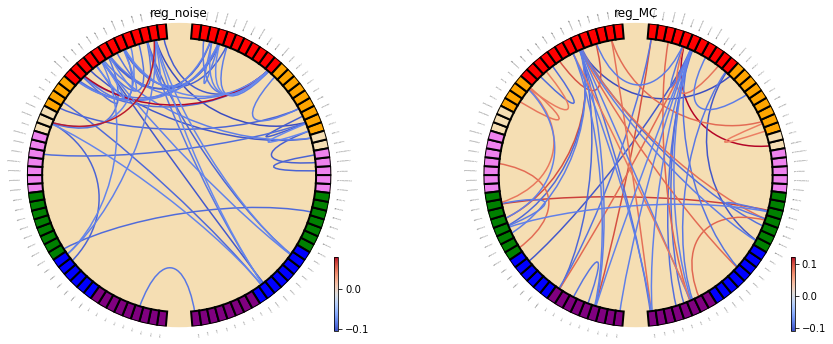

In [277]:
#Plot results of all 3 tasks
##Link: https://mne.tools/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html

fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=50,
                              textcolor='black', facecolor='wheat', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=10, colormap='coolwarm', 
                             fig=fig, subplot=(len(dfs), len(dfs), ii + 1), show = False)
     
plt.show()